In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Introducción a filtros de datos

Modelamos un objeto que se mueve a velocidad constante al cual podemos medir su posición pero con un cierto ruido. El método `move` nos da las posiciones reales y medidas del objeto mientras el objeto se mueve durante un periodo determinado de tiempo

In [2]:
class ConstantVelocityRobot(object):
    def __init__(self, init_pos=0., vel=1., mnoise=0.):
        self.pos = init_pos
        self.vel = vel
        self.mnoise = mnoise
        self.pos_history = [init_pos]
        self.m_history   = [self.measure_position()]
    
    def measure_position(self):
        return self.pos + np.random.normal(0, self.mnoise) if self.mnoise!=0 else self.pos
        
    def move(self):
        self.pos += self.vel
        self.pos_history.append(self.pos)
        self.m_history.append(self.measure_position())
    
    def move_n_time_steps(self, n):
        for t in range(n):
            self.move()
 

In [3]:
r = ConstantVelocityRobot(mnoise=0.1)
print r.pos, r.vel, r.measure_position()
r.move()
print r.pos, r.vel, r.measure_position()
r.move()
print r.pos, r.vel, r.measure_position()
print r.pos_history
print r.m_history

0.0 1.0 -0.0638964971647
1.0 1.0 1.03046028673
2.0 1.0 1.83483029453
[0.0, 1.0, 2.0]
[-0.048616798024965394, 1.0806076225281886, 1.9849952730203917]


In [4]:
r = ConstantVelocityRobot(mnoise=0.1)
r.move_n_time_steps(2)
print r.m_history

[0.1341111144092801, 0.9567816353594397, 1.9312240662787952]


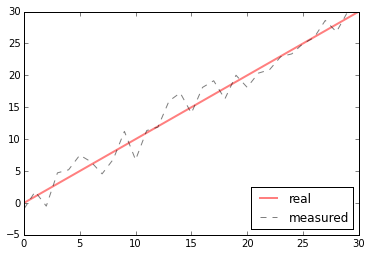

In [5]:
%run -i code/filter.py
o = ConstantVelocityRobot(mnoise=2)
o.move_n_time_steps(n=30)
real, measured = o.pos_history, o.m_history
plot_moves (real, measured)

La idea con la noción de filtros es combinar las medidas que obtenemos con nuestro conocimiento del movimiento del robot. Nuestra predicción de dónde creemos que estará el robot en el paso siguiente combina ambas cosas. Predecimos la posición y la velocidad, el parámetro $g$ controla la importancia relativa entre nuestra predicción y las medidas que obtenemos para la posición. El parámetro $h$ es análogo para la velocidad.

In [6]:
def predict_next_pos(x, v_est):
    return x + v_est

def compute_next_pos_and_vel(predicted_pos, measured_pos, vel, g, h):
    residual = measured_pos - predicted_pos    
    pos = predicted_pos + g * residual
    vel = vel + h*residual
    return pos, vel

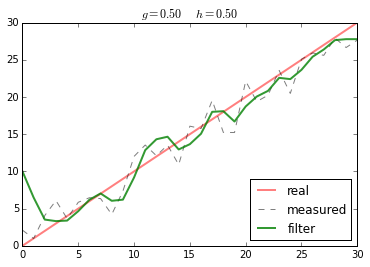

In [7]:
o = ConstantVelocityRobot(mnoise=2)
g,h = 0.5,0.5
fltr_vel = 2
fltr_pos = 10

o.move_n_time_steps(n=30)
real_pos_list, meas_pos_list = o.pos_history, o.m_history

fltr_pos_list = [fltr_pos]

for meas_pos in meas_pos_list[1:]:
    # predict
    pred_pos = predict_next_pos(fltr_pos, fltr_vel)

    # update
    fltr_pos, fltr_vel = compute_next_pos_and_vel(pred_pos, meas_pos, fltr_vel, g, h)

    fltr_pos_list.append(fltr_pos)
 
plot_moves(real_pos_list, meas_pos_list, fltr_pos_list, g, h)

## G-H Filter

lo que acabamos de hacer es un filtro G-H, pongamos su implementación dentro de una única función para que sea más fácil usarlo, y entender cómo establecer los parámetros $g$ y $h$ con distintos niveles de ruido.

In [8]:
def g_h_filter(measurements, init_pos, init_vel, g, h):
    fltr_pos      = init_pos
    fltr_vel      = init_vel
    fltr_pos_list = [init_pos]

    for meas_pos in measurements[1:]:
        # predict
        pred_pos = fltr_pos + fltr_vel

        # update
        residual = meas_pos - pred_pos
        fltr_pos = pred_pos + g * residual
        fltr_vel = fltr_vel + h * residual
    
        fltr_pos_list.append(fltr_pos) 
    return fltr_pos_list

In [9]:
g,h = 0.5, 0.5
o = ConstantVelocityRobot(mnoise=3, vel=1)
o.move_n_time_steps(n=30)
positions, measurements = o.pos_history, o.m_history

In [10]:
print measurements

[3.51983627129085, 2.8823374784438798, -1.8566884892661948, 9.716908011511427, 0.6883360414515893, 0.11141566760862887, 8.701071146050475, 12.02848995850183, 4.476790380657414, 7.0302385029083805, 7.9229940653361774, 12.529402109742934, 11.9117601729858, 13.76223851841134, 16.560745374913033, 18.040711466431144, 13.883582553159018, 15.537593051963665, 14.952046830169008, 19.645635832097764, 20.039916536997602, 21.05214569842328, 23.105696157288033, 24.034022945576645, 25.36147924554534, 19.854840697291507, 24.917571998845386, 29.653370632470974, 27.66839244483907, 27.7047709097812, 31.9849375898142]


Damos la misma importancia a la medición y la predicción

using g_h_filter at filter.py


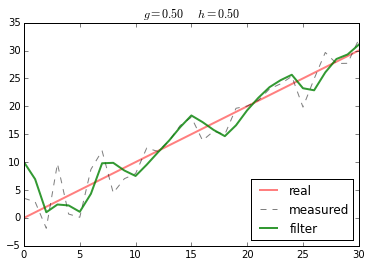

In [11]:
%run -i code/filter.py
g,h = .5, .5
filter_positions = g_h_filter(measurements, init_pos=10, init_vel=1, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

Empezamos con una estimación inicial muy erronea

using g_h_filter at filter.py


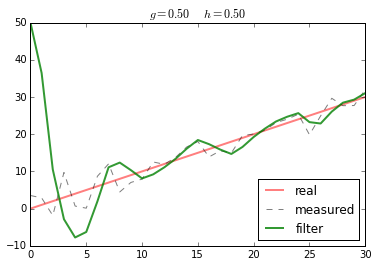

In [12]:
%run -i code/filter.py
g,h = .5, .5
filter_positions = g_h_filter(measurements, init_pos=50, init_vel=20, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

Damos mucha más importancia a la predicción de nuestro modelo y además tomamos la primera medición como nuestra estimación de posición inicial

using g_h_filter at filter.py


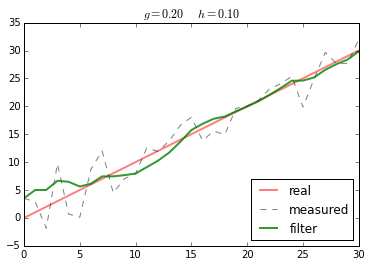

In [13]:
%run -i code/filter.py
g,h = .2,.1
filter_positions = g_h_filter(measurements, init_pos=measurements[0], init_vel=2, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

Empezamos con una estimación correcta de $pos$ pero incorrecta de $vel$

using g_h_filter at filter.py


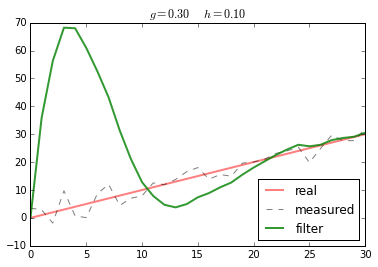

In [16]:
%run -i code/filter.py
g,h = .3,.1
filter_positions = g_h_filter(measurements, init_pos=0, init_vel=50, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

Damos mucha más importancia a la medición

using g_h_filter at filter.py


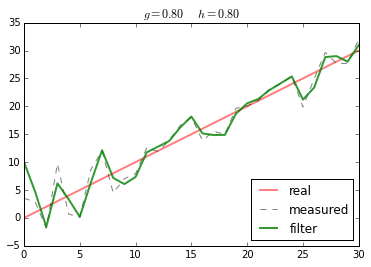

In [17]:
%run -i code/filter.py
g,h = .8,.8
filter_positions = g_h_filter(measurements, init_pos=10, init_vel=2, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

using g_h_filter at filter.py


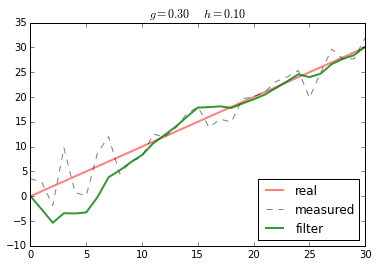

In [19]:
%run -i code/filter.py
g,h = .3,.1
filter_positions = g_h_filter(measurements, init_pos=0, init_vel=-5, g=g, h=h)
plot_moves(positions, measurements, filter_positions, g, h)

## Filtros probabilísticos

En este caso,  nuestra predicción y las mediciones no son valores puntuales, sino distribuciones gausianas que expresan la confianza que tenemos en cada una de ellas.

Asegúrate de entender la intuición detrás de la adición y multiplicación de distribuciones gausianas (Notas 03 - Apedice X1) ... [aquí](Notas%2003X%20-%20Apendice%20-%20Distribuciones%20Gaussianas.ipynb)

In [21]:
class KalmanFilter1D:
    def __init__(self, init_pos, init_pos_std, measurement_noise, init_vel_std):
        
        self.pos     = init_pos
        self.pos_std = init_pos_std
        self.mnoise  = measurement_noise
        self.vel_std = init_vel_std

    def update(self, measurement):
        self.pos, self.pos_std = multiply_gaussians(self.pos, self.pos_std, measurement, self.mnoise)


    def predict(self, init_vel=0.0):
        self.pos, self.pos_std = add_gaussians(self.pos, self.pos_std, init_vel, self.vel_std)
        
    def filter_data(self, data, init_vel=0.0):
        
        pos_history, pos_std_history = [self.pos], [self.pos_std]
        
        for i in range(len(data)-1):
            self.predict(init_vel)
            self.update(data[i])

            pos_history.append(self.pos)
            pos_std_history.append(self.pos_std)

        return np.array(pos_history), np.array(pos_std_history)

### Comparativas filtro G-H y Probabilístico

Con estimación inicial de velocidad correcta y gran incertidumbre en la posición inicial

using g_h_filter at filter.py


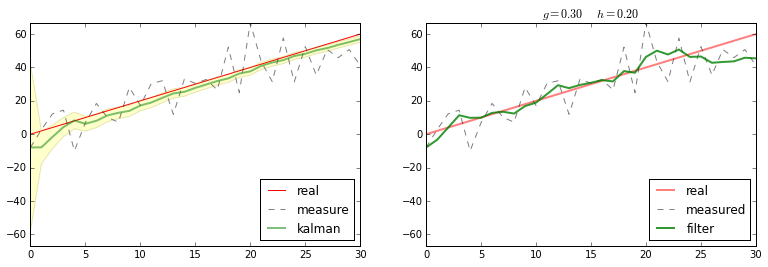

In [22]:
%run -i code/filter.py
mnoise = 10.
o = ConstantVelocityRobot(init_pos=0., vel=2., mnoise=mnoise)
o.move_n_time_steps(n=30)
pos, mpos = o.pos_history, o.m_history    
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=50, init_vel=2, init_vel_std=0, g=0.3, h=0.2, measurement_noise=o.mnoise)


Con gran incertidumbre también en la velocidad

using g_h_filter at filter.py


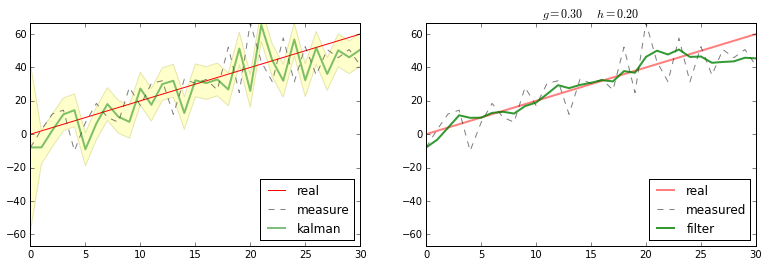

In [23]:
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=50, init_vel=2, init_vel_std=50, g=0.3, h=0.2, measurement_noise=o.mnoise)

Con estimación inicial de velocidad incorrecta

using g_h_filter at filter.py


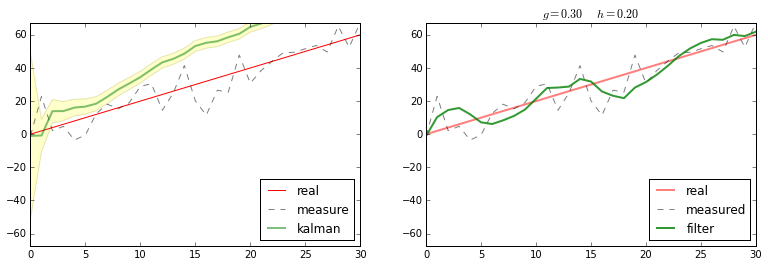

In [43]:
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=50, init_vel=6, init_vel_std=1, g=0.3, h=0.2, measurement_noise=o.mnoise)

Señal constante muy ruidosa

using g_h_filter at filter.py


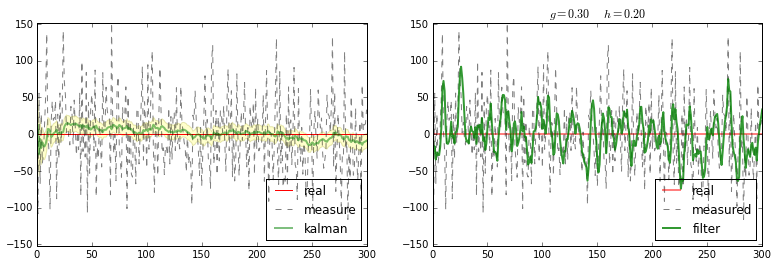

In [45]:
o = ConstantVelocityRobot(init_pos=0., vel=0., mnoise=50)
o.move_n_time_steps(n=300)
pos, mpos = o.pos_history, o.m_history
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=50, init_vel=0, init_vel_std=2, g=0.3, h=0.2, measurement_noise=o.mnoise)

### Filtro Kalman 1D con notación estándard

- $x_0$ estimación inicial de la posición
- $P$ incertidumbre en nuestra predicción
- $R$ ruido del sensor
- $Q$ ruido de la velocidad
- $z$ la medida recibida del sensor
- $u$ estimación de la velocidad

In [24]:
class KalmanFilter1D:
    def __init__(self, x0, P, R, Q):
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q

    def update(self, z):
        self.x, self.P = multiply_gaussians(self.x, self.P, z, self.R)


    def predict(self, u=0.0):
        self.x, self.P = add_gaussians(self.x, self.P, u, self.Q)
        
    def filter_data(self, data, u=0.0):
        
        x_history, P_history = [self.x], [self.P]
        for i in range(len(data)-1):
            self.predict(u)
            self.update(data[i])

            x_history.append(self.x)
            P_history.append(self.P)

        return np.array(x_history), np.array(P_history)


Con poca incertidumbre en la predicción ($init\_pos\_std$ bajo), si la estimación de la posición inicial ($init\_pos$) es incorrecta es dificil recuperarse

using g_h_filter at filter.py


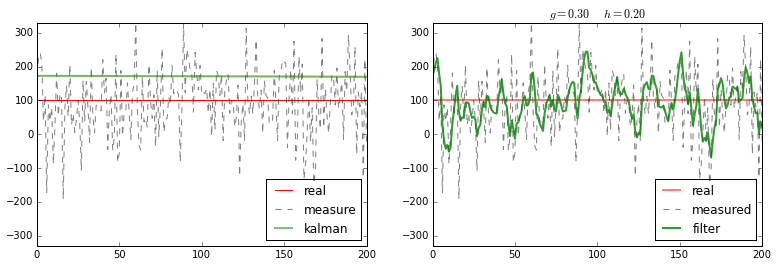

In [47]:
o = ConstantVelocityRobot(init_pos=100., vel=0., mnoise=100)
o.move_n_time_steps(n=200)
pos, mpos = o.pos_history, o.m_history
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=1, init_vel=0., init_vel_std=0.1, g=0.1, h=0.1 , measurement_noise=o.mnoise)


Con una estimación incorrecta de la posición inicial, si declaramos una incertidumbre grande Kalman acaba por converger

using g_h_filter at filter.py


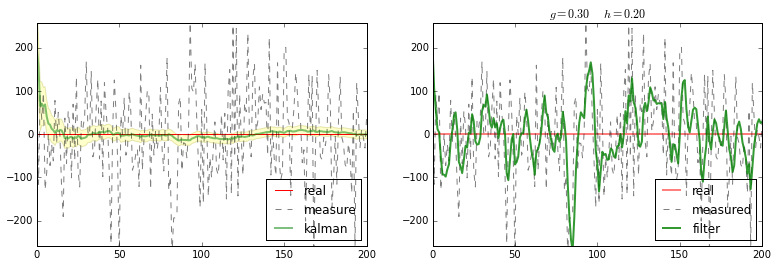

In [48]:
o = ConstantVelocityRobot(init_pos=0., vel=0., mnoise=100)
o.move_n_time_steps(n=200)
pos, mpos = o.pos_history, np.array(o.m_history)
plot_kalman_gh(pos, mpos, init_pos=200, init_pos_std=100, init_vel=0., init_vel_std=1., g=0.1, h=0.1 , measurement_noise=o.mnoise)


Perdemos ahora la señal durante 70 unidades de tiempo y seguimos con la última medición obtenida

using g_h_filter at filter.py


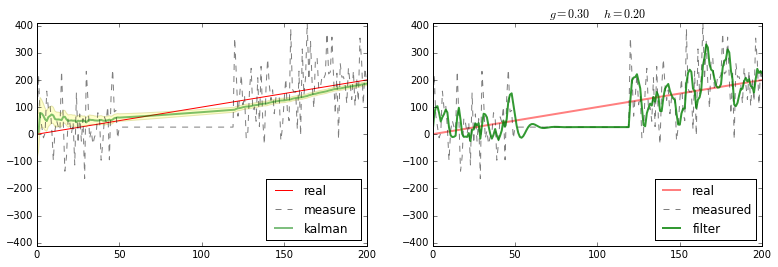

In [51]:
o = ConstantVelocityRobot(init_pos=0., vel=1., mnoise=100)
o.move_n_time_steps(n=200)
pos, mpos = o.pos_history, np.array(o.m_history)
mpos[50:120]=mpos[50]
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=100, init_vel=1., init_vel_std=0.1, 
               g=0.1, h=0.1 , measurement_noise=o.mnoise)

Si nuestra estimación inicial de la velocidad de partida es incorrecta y nos consideramos muy seguros de nuestra estimación, Kalman no se recupera

using g_h_filter at filter.py


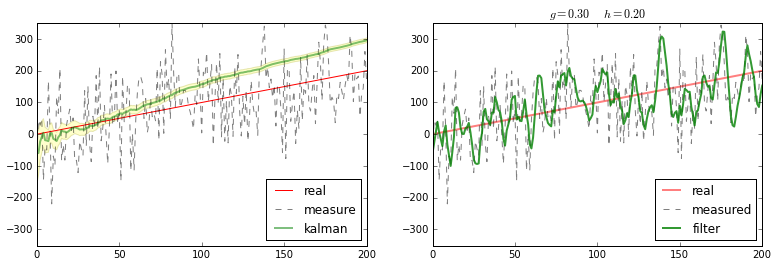

In [53]:
o = ConstantVelocityRobot(init_pos=0., vel=1., mnoise=100)
o.move_n_time_steps(n=200)
pos, mpos = o.pos_history, np.array(o.m_history)
plot_kalman_gh(pos, mpos, init_pos=mpos[0], init_pos_std=100, init_vel=2., init_vel_std=0.1, 
               g=0.1, h=0.1 , measurement_noise=o.mnoise)

## Refs

Simultaneous Localization and Mapping [web site](http://prism2.mem.drexel.edu/~billgreen/slam/slam.html)

Extended Kalman Filter for localization [ipynb](http://nbviewer.ipython.org/github/balzer82/PyData-Berlin-2014-Kalman/blob/master/Extended-Kalman-Filter-CTRV.ipynb) [web site](http://balzer82.github.io/PyData-Berlin-2014-Kalman/)

Ping-pong game [ipynb](http://nbviewer.ipython.org/github/balzer82/PyData-Berlin-2014-Kalman/blob/master/Kalman-Filter-CA-Ball.ipynb)